# Leer datasets

In [1]:
import pandas as pd
import numpy as np

breast_cancer = pd.read_csv('../../data/real/SAheart.csv')
breast_cancer.drop(columns=['row.names', "chd"], inplace=True)  # drop unnecessary column
breast_cancer["famhist"] = breast_cancer["famhist"].map({'Absent': 0, 'Present': 1})
# drop rows with NaN values
breast_cancer = breast_cancer.dropna()
print(breast_cancer.shape)
print(breast_cancer.columns)
print(breast_cancer.dtypes)
breast_cancer.head()

(462, 9)
Index(['sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 'obesity',
       'alcohol', 'age'],
      dtype='object')
sbp            int64
tobacco      float64
ldl          float64
adiposity    float64
famhist        int64
typea          int64
obesity      float64
alcohol      float64
age            int64
dtype: object


,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49


# Realizamos los clusters

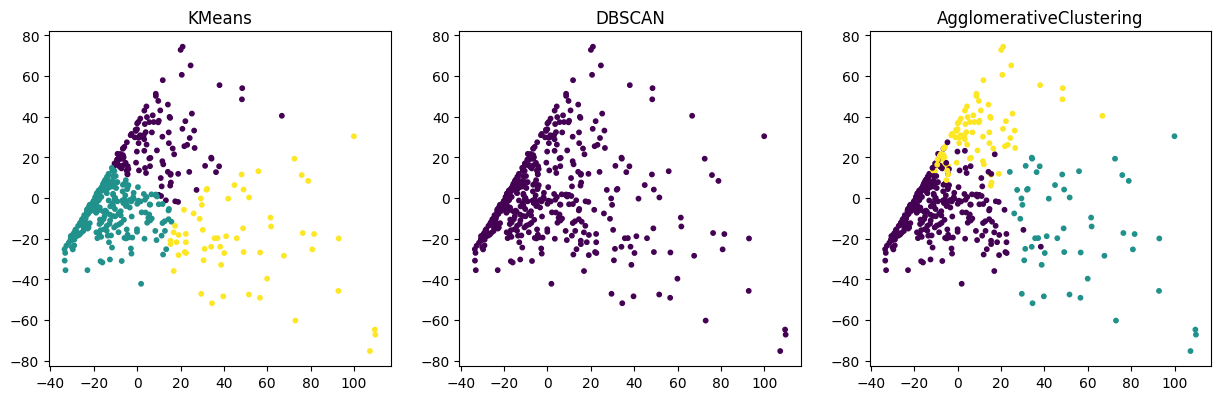

In [2]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering, AffinityPropagation, Birch, OPTICS, BisectingKMeans
from sklearn.mixture import GaussianMixture
n_clusters = 3
clustering_algorithms = {
    'KMeans': KMeans(n_clusters=n_clusters, random_state=42),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=3),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=n_clusters),
}
results = {}
for name, algorithm in clustering_algorithms.items():
    try:
        algorithm.fit(breast_cancer)
        if hasattr(algorithm, 'labels_'):
            labels = algorithm.labels_
        elif hasattr(algorithm, 'predict'):
            labels = algorithm.predict(breast_cancer)
        else:
            labels = algorithm.means_.argmax(axis=0)  # For GaussianMixture
        results[name] = labels
    except Exception as e:
        print(f"Error with {name}: {e}")
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
breast_cancer_pca = pca.fit_transform(breast_cancer)
plt.figure(figsize=(15, 20))
for i, (name, labels) in enumerate(results.items(), 1):
    plt.subplot(4, 3, i)
    plt.scatter(breast_cancer_pca[:, 0], breast_cancer_pca[:, 1], c=labels, cmap='viridis', s=10)
    plt.title(name)

In [3]:
for eps in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for min_samples in [3, 4, 5, 6]:
        for metric in ['euclidean', 'manhattan']:
            #printeamos numero de labels
            c= DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            c.fit(breast_cancer)
            if len(np.unique(c.labels_))>1:
                print(np.unique(c.labels_, return_counts=True))

In [4]:
#definimos dunn index
def dunn_index(data, labels):
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return 0.0

    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i = data[labels == unique_labels[i]]
            cluster_j = data[labels == unique_labels[j]]
            inter_distance = np.linalg.norm(cluster_i.mean(axis=0) - cluster_j.mean(axis=0))
            inter_cluster_distances.append(inter_distance)

        intra_distance = np.mean([np.linalg.norm(data[labels == unique_label] - data[labels == unique_label].mean(axis=0)) for unique_label in unique_labels])
        intra_cluster_distances.append(intra_distance)

    dunn_index_value = min(inter_cluster_distances) / max(intra_cluster_distances)
    return dunn_index_value

In [5]:
#podrias generar una metrica en que se calcule el valor maximo de distancia (entre las menores distancias de cada punto con otro dentro del mismo cluster) dividido por el valor minimo de distancia entre cualquier punto de un cluster con otro punto de otro cluster
import numpy as np
from sklearn.metrics import pairwise_distances

def custom_metric(X, labels):
    X = np.array(X)
    distances = pairwise_distances(X)
    n = len(X)
    
    # Numerador: máximo de las mínimas distancias dentro del mismo cluster
    max_min_intra = -np.inf
    for i in range(n):
        same_cluster = (labels == labels[i])
        same_cluster[i] = False  # Exclude itself
        if np.any(same_cluster):
            min_dist = np.min(distances[i][same_cluster])
            max_min_intra = max(max_min_intra, min_dist)
    
    # Denominador: mínima distancia entre puntos de distintos clusters
    min_inter = np.inf
    for i in range(n):
        other_cluster = (labels != labels[i])
        if np.any(other_cluster):
            min_dist = np.min(distances[i][other_cluster])
            min_inter = min(min_inter, min_dist)

    M = max_min_intra / min_inter if min_inter != 0 else np.inf
    return 1 /( 1 + M)


In [6]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from permetrics import ClusteringMetric
def evaluate_clustering(data, labels):
    if len(set(labels)) < 2:
        return {
            'Silhouette Score': None,
            'Calinski-Harabasz Score': None,
            'Davies-Bouldin Score': None,
            'Dunn Index': None,
            'custom_metric': None,
            'dbcv': None
        }
    
    silhouette = silhouette_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    dunn = dunn_index(data.values, labels)
    custom = custom_metric(data.values, labels)
    dbcv = ClusteringMetric(X=data.values, y_pred=labels).DBCVI()

    return {
        'Silhouette Score': silhouette,
        'Calinski-Harabasz Score': calinski_harabasz,
        'Davies-Bouldin Score': davies_bouldin,
        'Dunn Index': dunn,
        'custom_metric': custom,
        'dbcv': dbcv
    }
evaluation_results = {}
for name, labels in results.items():
    evaluation_results[name] = evaluate_clustering(breast_cancer, labels)
evaluation_df = pd.DataFrame(evaluation_results).T
evaluation_df = evaluation_df.rename(columns={
    'Silhouette Score': 'Silhouette',
    'Calinski-Harabasz Score': 'Calinski-Harabasz',
    'Davies-Bouldin Score': 'Davies-Bouldin',
    'Dunn Index': 'Dunn',
    'custom_metric': 'Custom Metric'
})
evaluation_df

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv
KMeans,0.302061,212.763113,1.15231,0.118365,0.197114,0.943473
DBSCAN,None,None,None,None,None,None
AgglomerativeClustering,0.282456,186.260008,1.122658,0.122139,0.196113,0.956625


In [7]:
#elige los mejores 3 resultados ponderando el orden de cada métrica
def weighted_score(row):
    weights = {
        'Silhouette': 0.2,
        'Calinski-Harabasz': -0.2,
        'Davies-Bouldin': 0.2,  # Negativo porque queremos minimizar
        'Dunn': 0.2,
        'Custom Metric': 0.5 # Puedes ajustar este peso según su importancia
    }
    score = (row['Silhouette'] * weights['Silhouette'] +
                1/(1+row['Calinski-Harabasz']) * weights['Calinski-Harabasz'] +
                1/(1+row['Davies-Bouldin']) * weights['Davies-Bouldin'] +
                row['Dunn'] * weights['Dunn'] +
                row['Custom Metric'] * weights['Custom Metric'])
    return score
# Replace None values with 0 for scoring
evaluation_df_filled = evaluation_df.fillna(0)
evaluation_df_filled['Weighted Score'] = evaluation_df_filled.apply(weighted_score, axis=1)
top_3_algorithms = evaluation_df_filled.nlargest(3, 'Weighted Score')
top_3_algorithms

/tmp/ipykernel_234307/2114172724.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  evaluation_df_filled = evaluation_df.fillna(0)


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv,Weighted Score
KMeans,0.302061,212.763113,1.152310,0.118365,0.197114,0.943473,0.274630
AgglomerativeClustering,0.282456,186.260008,1.122658,0.122139,0.196113,0.956625,0.272129
DBSCAN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Interpretar

In [8]:
import sys
sys.path.append('../..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

In [ ]:
#comparar centroides kmeans

Processing KMeans with 3 clusters
Ripper Accuracy for KMeans: 0.88
Ripper Rules:

Reglas para clase: 0
[[sbp=>164.0] V [sbp=152.0-164.0^ldl=>7.4] V [sbp=152.0-164.0^ldl=6.19-7.4] V [sbp=144.0-152.0^ldl=6.19-7.4] V [sbp=152.0-164.0^alcohol=<1.3] V [age=>61.0^sbp=134.0-138.0] V [sbp=144.0-152.0^ldl=>7.4] V [sbp=138.0-144.0^adiposity=32.01-34.5] V [adiposity=29.56-32.01^sbp=138.0-144.0] V [sbp=144.0-152.0^typea=61.4-66.0] V [adiposity=>34.5^sbp=138.0-144.0]]

Reglas para clase: 1
[[tobacco=<0.4^age=<18.0] V [sbp=126.0-130.0] V [sbp=116.0-122.0] V [sbp=<116.0] V [sbp=122.0-126.0] V [sbp=130.0-134.0^alcohol=<1.3] V [sbp=130.0-134.0^alcohol=11.11-17.63] V [age=33.0-40.0^sbp=138.0-144.0] V [alcohol=17.63-25.28^sbp=130.0-134.0] V [age=18.0-28.0^sbp=144.0-152.0] V [age=28.0-33.0^famhist=0] V [sbp=130.0-134.0^alcohol=1.3-3.1] V [sbp=138.0-144.0^obesity=23.53-24.74] V [obesity=25.81-26.7^sbp=138.0-144.0] V [age=33.0-40.0^sbp=144.0-152.0]]

Reglas para clase: 2
[[alcohol=>43.03]]
Decision Tree Acc

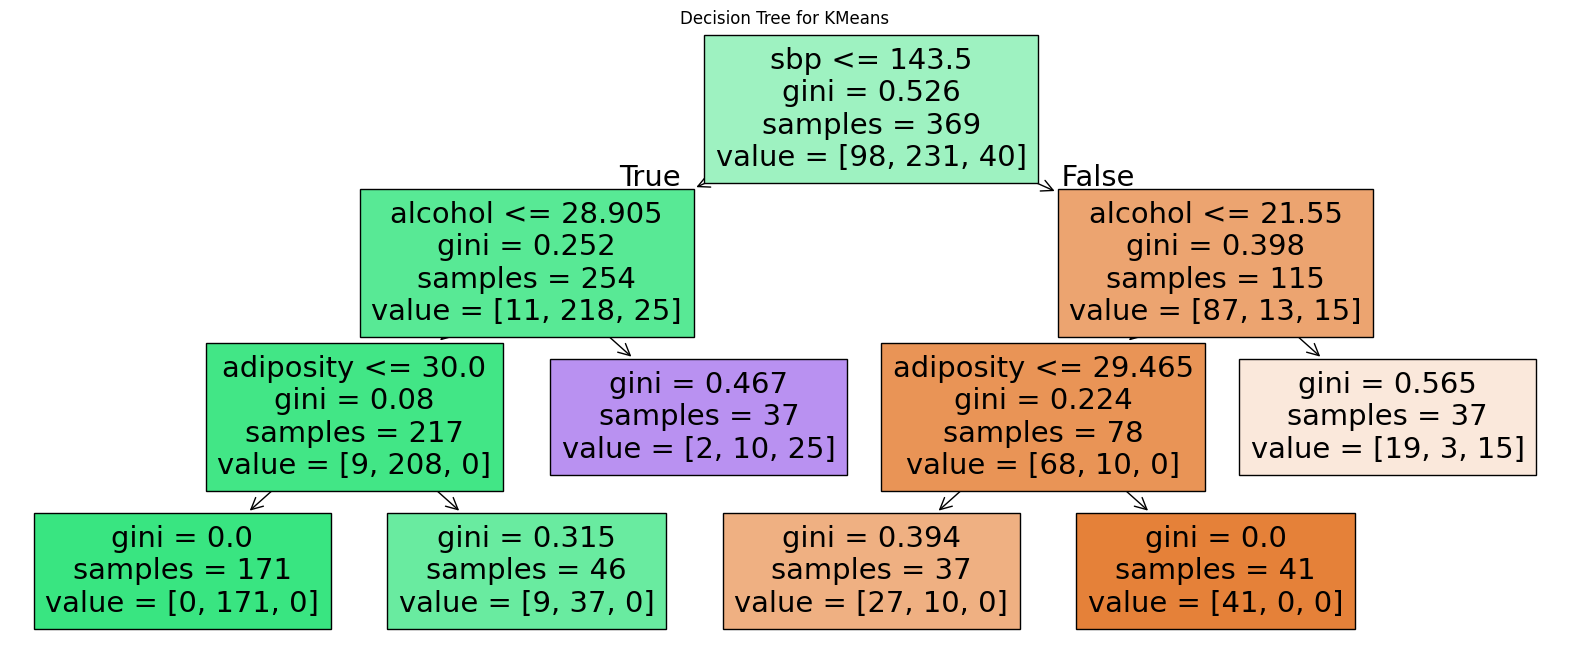

Optimization started

Training time: 13.65s, epochs: 200

Least training loss reached: 0.038
DSGD Accuracy for KMeans: 0.87
DSGD Rules:


Most important rules for class 0

	[0.877] R3: sbp > 151.625
			0: 0.809	1: 0.000	2: 0.141	Unc: 0.050

	[0.714] R28: 15.338 < alcohol < 30.134
			0: 0.510	1: 0.490	2: 0.000	Unc: 0.000

	[0.690] R11: ldl > 6.175
			0: 0.515	1: 0.410	2: 0.000	Unc: 0.075

	[0.688] R27: 0.541 < alcohol < 15.338
			0: 0.475	1: 0.521	2: 0.000	Unc: 0.004

	[0.626] R2: 137.976 < sbp < 151.625
			0: 0.626	1: 0.000	2: 0.000	Unc: 0.374

	[0.574] R33: age > 52.719
			0: 0.574	1: 0.000	2: 0.000	Unc: 0.426

	[0.537] R15: adiposity > 30.224
			0: 0.452	1: 0.187	2: 0.000	Unc: 0.361

	[0.504] R32: 42.775 < age < 52.719
			0: 0.342	1: 0.402	2: 0.000	Unc: 0.256

	[0.486] R26: alcohol < 0.541
			0: 0.291	1: 0.518	2: 0.000	Unc: 0.191

	[0.374] R7: tobacco > 6.622
			0: 0.248	1: 0.000	2: 0.316	Unc: 0.436

Most important rules for class 1

	[0.720] R27: 0.541 < alcohol < 15.338
			0: 0.475

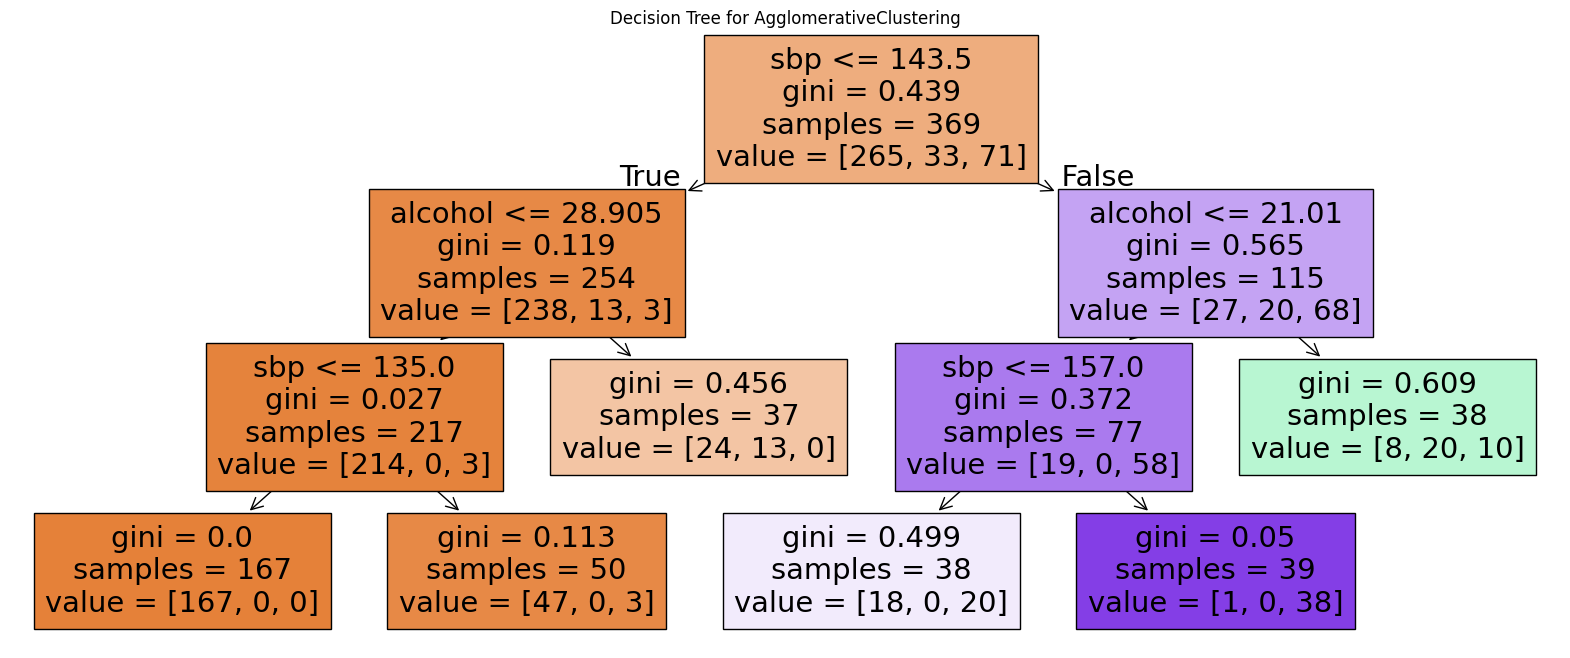

Optimization started

Training time: 13.77s, epochs: 200

Least training loss reached: 0.044
DSGD Accuracy for AgglomerativeClustering: 0.89
DSGD Rules:


Most important rules for class 0

	[0.637] R27: 0.541 < alcohol < 15.338
			0: 0.456	1: 0.000	2: 0.432	Unc: 0.112

	[0.606] R28: 15.338 < alcohol < 30.134
			0: 0.528	1: 0.000	2: 0.167	Unc: 0.305

	[0.581] R18: typea < 46.624
			0: 0.581	1: 0.000	2: 0.000	Unc: 0.419

	[0.579] R0: sbp < 124.326
			0: 0.579	1: 0.000	2: 0.000	Unc: 0.421

	[0.556] R1: 124.326 < sbp < 137.976
			0: 0.556	1: 0.000	2: 0.000	Unc: 0.444

	[0.521] R30: age < 32.831
			0: 0.521	1: 0.000	2: 0.000	Unc: 0.479

	[0.477] R26: alcohol < 0.541
			0: 0.314	1: 0.000	2: 0.411	Unc: 0.274

	[0.472] R11: ldl > 6.175
			0: 0.348	1: 0.000	2: 0.293	Unc: 0.359

	[0.468] R7: tobacco > 6.622
			0: 0.426	1: 0.088	2: 0.000	Unc: 0.486

	[0.463] R4: tobacco < 0.516
			0: 0.463	1: 0.000	2: 0.000	Unc: 0.537

	[0.435] R23: 23.149 < obesity < 26.048
			0: 0.435	1: 0.000	2: 0.000	Unc: 0.5

preprocess.py.py: ._get_pos_class: RuntimeWarning: 
No negative samples. All target labels=1.

ripper.py: .fit: RuntimeWarning: 
No negative samples. Existing target labels=[1].

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.



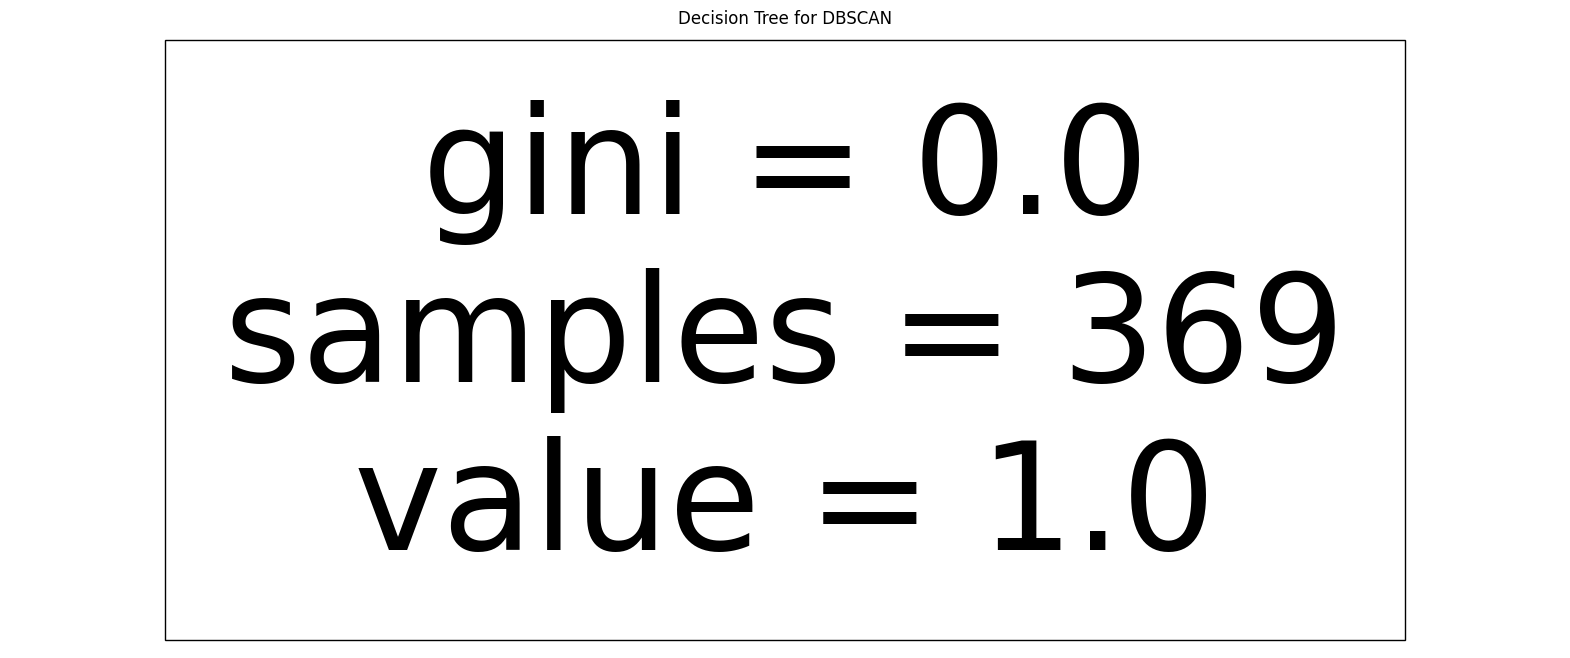

Optimization started

Training time: 1.41s, epochs: 22

Least training loss reached: 0.000
DSGD Accuracy for DBSCAN: 1.00
DSGD Rules:


Most important rules for class 0
--------------------------------------------------------------------------------


In [9]:
# interpretamos solo los mejores 3 resultados y guardamos los modelos
saved_models = {}
top_3_labels = {name: results[name] for name in top_3_algorithms.index}
top_3_data = breast_cancer.copy()
for name, labels in top_3_labels.items():
    n = len(np.unique(labels))
    X_train, X_test, y_train, y_test = train_test_split(top_3_data, labels, test_size=0.2, random_state=42)
    print(f'Processing {name} with {n} clusters')
    
    # Ripper
    ripper = MultiClassRipperClassifier(random_state=43)
    ripper.fit(X_train, y_train)
    y_pred_ripper = ripper.predict(X_test)
    print(f'Ripper Accuracy for {name}: {accuracy_score(y_test, y_pred_ripper):.2f}')
    print('Ripper Rules:')
    ripper.print_rules()
    saved_models.setdefault(name, {})['ripper'] = ripper
    
    # Decision Tree
    dtree = DecisionTreeClassifier(random_state=42, max_depth=5, min_weight_fraction_leaf=0.1)
    dtree.fit(X_train, y_train)
    dtree_pred = dtree.predict(X_test)
    print(f'Decision Tree Accuracy for {name}: {accuracy_score(y_test, dtree_pred):.2f}')
    plt.figure(figsize=(20, 8))
    sk_tree.plot_tree(dtree, filled=True, feature_names=X_train.columns)
    plt.title(f'Decision Tree for {name}')
    plt.show()
    saved_models[name]['dtree'] = dtree
    
    # DSGD
    max_label = np.max(labels)
    y_train = np.where(y_train == -1, max_label + 1, y_train)
    y_test = np.where(y_test == -1, max_label + 1, y_test)
    ds = DSClassifierMultiQ(n, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
    X = X_train.to_numpy()
    losses, epoch, dt = ds.fit(X, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=X_train.columns)
    x_test = X_test.to_numpy()
    y_pred_ds = ds.predict(x_test)
    print(f'DSGD Accuracy for {name}: {accuracy_score(y_test, y_pred_ds):.2f}')
    print('DSGD Rules:')
    ds.print_most_important_rules(threshold=0.32)
    saved_models[name]['ds'] = ds
    
    print('--' * 40)
